# Init

In [ ]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing, visualization
import matplotlib.pyplot as plt

logger = logging.getLogger("beta2")


## Load data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [2]:
working_dir = os.path.expanduser("~/projects/gpcr/mega/Result_Data/beta2-dror/clustering/")
raw_data = np.load(working_dir + "frame_distances_CA_inv.npy")
scale_data = True
#data = np.load(home_dir + "training_samples_CA_inv.npy")
cluster_indices = np.loadtxt(working_dir + 'cluster_indices_.txt')
data = utils.vectorize(raw_data)  # Our training data to classifiers
labels = utils.create_class_labels(cluster_indices)  #Our training labels to classifiers
feature_to_resids = np.load(
    working_dir + "feature_to_resids_CA.npy")  #Mapping from residue Id to the index of that residue in the data (for proteins with missing residues)
if len(data) != len(labels) or data.shape[1] != len(feature_to_resids):
    raise Exception()
logger.info("Loaded data of shape %s and %s clusters", data.shape, len(set(cluster_indices)))


2018-10-29 19:10:07 beta2-INFO: Loaded data of shape (857, 40186) and 3 clusters


## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [3]:
n_iterations, n_splits = 1, 1
feature_extractors = [
    fe.MlpFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    #fe.ElmFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.KLFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    #fe.PCA_feature_extract(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    #fe.RF_feature_extract(data, labels, n_splits=n_splits, n_iterations=n_iterations),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2018-10-29 19:10:13 beta2-INFO: Done. using 2 feature extractors


# Run the relevance analysis

In [4]:
results = []
for extractor in feature_extractors:
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance))
logger.info("Done")


2018-10-29 19:10:15 beta2-INFO: Computing relevance for extractors MLP
2018-10-29 19:10:15 Extracting feature-INFO: Using all data in training and validation sets
2018-10-29 19:10:15 Extracting feature-DEBUG: Iteration 1 of 1
2018-10-29 19:10:38 Extracting feature-DEBUG: Error: 0.0
2018-10-29 19:10:38 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-29 19:10:39 beta2-INFO: Computing relevance for extractors KL
2018-10-29 19:10:39 Extracting feature-INFO: Using all data in training and validation sets
2018-10-29 19:10:39 Extracting feature-DEBUG: Iteration 1 of 1


/home/oliverfl/anaconda2/envs/py2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/oliverfl/anaconda2/envs/py2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/oliverfl/anaconda2/envs/py2/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/oliverfl/anaconda2/envs/py2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/oliverfl/anaconda2/envs/py2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2018-10-29 19:10:44 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-29 19:11:06 beta2-INFO: Done


# Remap and persist results 

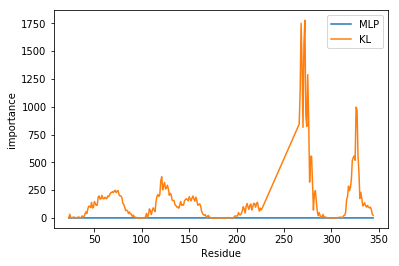

2018-10-29 19:11:08 beta2-INFO: Done


In [5]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance) in results:
    p = postprocessing.PostProcessor(extractor, feature_importance, std_feature_importance, cluster_indices,
                                     working_dir, feature_to_resids=feature_to_resids)
    p.average()
    p.persist()
    postprocessors.append(p)

logger.info("Done")


In [ ]:
# Visualize results
visualization.visualize(postprocessors)